# Creating Activation Atlases with captum.optim

This notebook demonstrates the use of the captum.optim submodule for creation of [Activation Atlases](https://distill.pub/2019/activation-atlas/) for the InceptionV1 model imported from Caffe. If you are looking for class activation atlases, they can be found in the second atlas tutorial [ClassActivationAtlas](https://).

Activation atlases provide a big picture overview of how a model represents various concepts, by using samples from the manifold of likely activations. Activation atlases can also show us the relationships between concepts, and they make it possible to identify possible adversarial attacks.


In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from captum.optim._models.inception_v1 import googlenet

import captum.optim as opt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device).eval()

We'll begin by defining some helper functions that will be explained in greater detail later on in the tutorial.

In [ ]:
from typing import List, Optional, Tuple, Union
from PIL import Image


def show(
    x: torch.Tensor, figsize: Optional[Tuple[int, int]] = None, scale: float = 255.0
) -> None:
    """
    Show CHW & NCHW tensors as an image.
    Args:
        x (torch.Tensor): The tensor you want to save as an image.
        figsize (Tuple[int, int], optional): height & width to use
            for displaying the image figure.
        scale (float): Value to multiply the input tensor by so that
            it's value range is [0-255] for display.
    """
    assert x.dim() == 3 or x.dim() == 4
    x = x[0] if x.dim() == 4 else x
    x = x.cpu().permute(1, 2, 0) * scale
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.imshow(x.numpy().astype(np.uint8))
    plt.axis("off")
    plt.show()


def save_tensor_as_image(x: torch.Tensor, filename: str, scale: float = 255.0) -> None:
    """
    Save CHW & NCHW image tensors as images.
    Args:
        x (torch.Tensor): The tensor you want to save as an image.
        filename (str): The filename to use when saving the image.
        scale (float, optional): Value to multiply the input tensor by so that
            it's value range is [0-255] for saving.
    """
    assert x.dim() == 3 or x.dim() == 4
    x = x[0] if x.dim() == 4 else x
    x = x.clone().detach().cpu().permute(1, 2, 0) * scale
    colorspace = "RGB" if x.shape[2] == 3 else "RGBA"
    im = Image.fromarray(x.numpy().astype(np.uint8), colorspace)
    im.save(filename)


def create_alpha_mask(
    h: int,
    w: int,
    coords: List[Union[Tuple[int, int, int], Tuple[int, int]]],
    device: torch.device = torch.device("cpu"),
) -> torch.tensor:
    """
    Create an alpha mask to make an activation atlas background transparent.

    Args:
       h (int): The height of each cell.
       w (int): the width of each cell.
       coords (List[Union[Tuple[int, int, int], Tuple[int, int]]]): A list of
           atlas coordinates to use for creating the mask.
       device (torch.device, optional): The device that the cells are on.
    Returns:
       alpha_mask (torch.Tensor): An alpha mask tensor used to make an atlas
           background transparent.
    """

    return opt.atlas.create_atlas(
        [torch.ones(1, 1, h, w, device=device) for n in coords],
        coords,
        grid_size=grid_size,
        base_tensor=torch.zeros,
    )


def extract_grid_attributions(
    grid_indices: List[List[torch.Tensor]],
    raw_attributions: torch.Tensor,
    grid_size: Tuple[int, int],
    target_class_ids: Union[int, List[int]],
    min_density: int = 8,
) -> torch.Tensor:
    """
    Collect cell attributions for the specific grid indices. Grid cells
    without the minimum number of indices as specified by min_density will be
    ignored.

    Args:
        grid_indices (list of list of torch.tensor): List of lists of grid indices to
            use.
        raw_attributions (torch.tensor): Sample attributions, with a shape
            of: [n_samples, n_classes].
        grid_size (Tuple[int, int]): The grid_size of grid cells to use. The grid_size
            variable should be in the format of: [width, height].
        target_class_ids (int or list of int): The target classes to extract cell
            attributions for.
        min_density (int, optional): The minimum number of points for a cell to be
            counted.
    Returns:
        cell_attributions (torch.tensor): A tensor containing all the cell attributions.
    """

    assert raw_attributions.dim() == 2
    cell_coords: List = []
    average_attributions: List = []
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            indices = grid_indices[x][y]
            if len(indices) >= min_density:
                average_attributions.append(
                    torch.mean(raw_attributions[indices][:, target_class_ids], 0)
                )
    return torch.stack(average_attributions)

## Atlas Setup

To create an activation atlas for our model, we need to collect neuron activation samples from the dataset that the model was trained on. In the case of the Inception V1 model, we use the training images from ImageNet's ILSVRC2012 dataset. 

Samples are collected by first randomly collecting a neuron activation sample with a shape of: `1, channels, 1, 1` for every image in the batch. We avoid edge neurons to improve activation atlas quality by only collecting neuron samples from between `[1, height -1]` and `[1, width -1]`. The neuron class attributions are then estimated by determining the rate at which increasing the neuron affects the output classes.

Due to the size of the ILSVRC2012 dataset, we'll skip the sample collection step and just download some pre-collected samples. If you do however want to collect your own samples then you can follow the steps below.

### Dataset Download & Activation Sample Collection (Optional)
You can download ImageNet's ILSVRC2012 dataset from the [ImageNet website](http://www.image-net.org/challenges/LSVRC/2012/) or via BitTorrent from [Academic Torrents](https://academictorrents.com/details/a306397ccf9c2ead27155983c254227c0fd938e2). Once the dataset is downloaded, you can then load it with a `torch.utils.DataLoader` instance, and Torchvision's `torchvision.datasets.ImageNet`.


With the ImageNet ILSVRC2012 dataset loaded, you can randomly sample an x and y position in every image for all specified target layers with Captum's `capture_activation_samples` function. The sample collection function takes two versions of the input model, one for activation samples and a second for attribution samples. Both versions of the input model should have the same layer targets. By default the activation samples will not have the right class attributions, so we remedy this by replacing all the `nn.MaxPool2d` layers in our attribution version of the model with Captum's `MaxPool2dRelaxed` layer.

In [ ]:
"""
collect_attributions = True  # Set to False for no attributions

# Load dataset with basic transforms & set desired batch size.
# The model has the normalization step in its internal transform_input
# function, so we don't need to normalize our inputs here.
transform_list = [
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
]
transform_list = torchvision.transforms.Compose(transform_list)
image_dataset = torchvision.datasets.ImageNet(
    root="path/to/dataset", split="train", transform=transform_list
)
image_loader = torch.utils.data.DataLoader(
    image_dataset,
    batch_size=32,
    shuffle=True,
)


# Directory to save sample tensor files to
sample_dir = "inceptionv1_samples"


# Model to collect samples from, what layers of the model to collect samples from,
# and the desired names to use for the target layers.
sample_model = (
    googlenet(
        pretrained=True, replace_relus_with_redirectedrelu=False, bgr_transform=True
    )
    .eval()
    .to(device)
)
sample_targets = [sample_model.mixed4c_relu]
sample_target_names = ["mixed4c_relu_samples"]


# Optionally collect attributions from a copy of the first model that's
# been setup with relaxed pooling layers.
if collect_attributions:
    sample_model_attr = (
        googlenet(
            pretrained=True, replace_relus_with_redirectedrelu=False, bgr_transform=True
        )
        .eval()
        .to(device)
    )
    opt.models.replace_layers(
        sample_model_attr,
        torch.nn.MaxPool2d,
        opt.models.MaxPool2dRelaxed,
        transfer_vars=True,
    )
    sample_attr_targets = [sample_model_attr.mixed4c_relu]
    sample_logit_target = sample_model_attr.fc
else:
    sample_model_attr = None
    sample_attr_targets = None
    sample_logit_target = None


# Collect samples & optionally attributions as well
opt.dataset.capture_activation_samples(
    loader=image_loader,
    model=sample_model,
    targets=sample_targets,
    target_names=sample_target_names,
    attr_model=sample_model_attr,
    attr_targets=sample_attr_targets,
    input_device=device,
    sample_dir=sample_dir,
    show_progress=True,
    collect_attributions=collect_attributions,
    logit_target=sample_logit_target,
)


# Combine our newly collected samples into single tensors.
# We load the sample tensors from sample_dir and then
# concatenate them.
activation_samples = opt.dataset.consolidate_samples(
    sample_dir=sample_dir,
    sample_basename=sample_target_names[0] + "_activations_",
    dim=1,
    show_progress=True,
)
if collect_attributions:
    sample_attributions = opt.dataset.consolidate_samples(
        sample_dir=sample_dir,
        sample_basename=sample_target_names[0] + "_attributions_",
        dim=0,
        show_progress=True,
    )
"""

### Download Pre-collected Activations & Attributions

Before we can start the main tutorial, you'll first have to download a set of pre-collected activation and attribution samples for Mixed4c ReLU layer of our model. To make things easier for the tutorial we'll only use 100,000 activation & attribution samples. The sample attributions were collected using a relaxed version of model where all of the `nn.MaxPool2d` layers were replaced with Captum's `MaxPool2dRelaxed` layer.

In [ ]:
fileurl = "https://pytorch-tutorial-assets.s3.amazonaws.com/captum/"

activation_samples = torch.hub.load_state_dict_from_url(
    url=fileurl + "inceptionv1_mixed4c_relu_samples_activations.pt",
    progress=True,
).to(device)

sample_attributions = torch.hub.load_state_dict_from_url(
    url=fileurl + "inceptionv1_mixed4c_relu_samples_attributions.pt",
    progress=True,
).to(device)

### Dimensionality Reduction For Activation Atlas Coordinate Grid Creation

After loading our dataset activation samples for the Mixed4c ReLU layer, we can use either [UMAP](https://umap-learn.readthedocs.io/en/latest/) or Sklearn's [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to reduce the number of channels to 2. By reducing the number of channels in our activation samples to 2, we turn the data in a grid of x and y coordinates that we can then graph and visualize!

In [ ]:
import umap

c_reducer = opt.reducer.ChannelReducer(
    n_components=2,
    reduction_alg=umap.UMAP,
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
)
# You can also use TSNE instead of UMAP if desired:
# from sklearn.manifold import TSNE
# c_reducer = opt.reducer.ChannelReducer(
#    n_components=2,
#    reduction_alg=TSNE,
#    verbose=True,
#    metric="cosine",
#    learning_rate=10,
#    perplexity=50,
# )

xy_grid = c_reducer.fit_transform(activation_samples.to("cpu")).to(device)

UMAP(a=None, angular_rp_forest=True, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='cosine', metric_kwds=None,
     min_dist=0.01, n_components=2, n_epochs=None, n_jobs=-1, n_neighbors=20,
     negative_sample_rate=5, output_dens=False, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, ...)
Construct fuzzy simplicial set
Sun Apr 18 14:41:08 2021 Finding Nearest Neighbors
Sun Apr 18 14:41:08 2021 Building RP forest with 21 trees
Sun Apr 18 14:41:17 2021 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	Stopping threshold met -- exiting after 6 iterations
Sun Apr 18 14:41:56 2021 Finished Nearest Neighbor S

Now that we have our two dimensional grid of x and y coordinates for our reduced activation samples, we need to normalize it. We can use Captum.optim's `normalize_grid` function to both remove outliers and to rescale the values of our graph to between 0 and 1.

In [ ]:
# Normalize xy_grid for graphing
normalized_xy_grid = opt.atlas.normalize_grid(xy_grid)

After normalizing the xy grid, it is possible to plot the results using a graphing library like `matplotlib`. Note that the shape of the plotted graph will be the same shape as the full activation atlas!

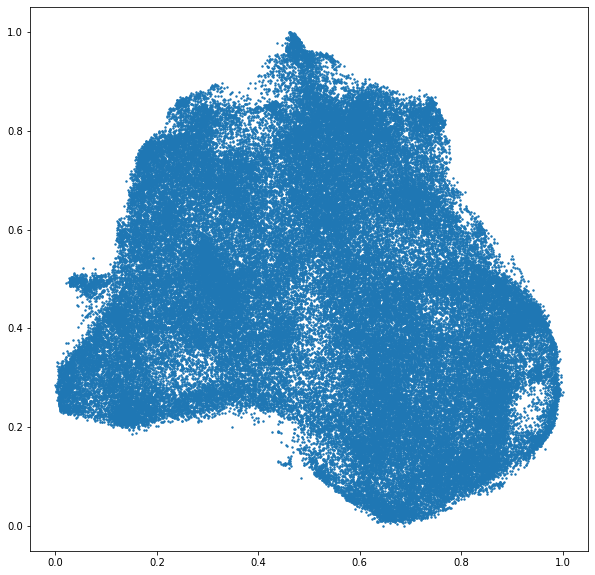

In [ ]:
# Show the normalized xy coordinate grid
plt.figure(figsize=(10, 10))
plt.scatter(x=normalized_xy_grid[:, 0].cpu(), y=normalized_xy_grid[:, 1].cpu(), s=2)
plt.show()

## Activation Atlas Vectors & Coordinates

Now we can use both the raw activation samples and our xy coordinate grid to create the direction vectors that are required for rendering the atlas visualizations. To create the direction vectors we will used Captum.optim's `create_atlas_vectors` function:

* The `xy_grid` parameter is our xy coordinate grid.
* The `raw_activations` parameter is for the unmodified activation samples (that can optionally be filtered beforehand).
* The `grid_size` parameter defines how big our atlas should be, with the number of visualizations for each dimension in the form of: (`width, height`).
* The `min_density` parameter specifies the minimum number of sample points a cell requires to be counted.
* The `normalize` parameter determines whether `xy_grid` requires normalization.

The `create_atlas_vectors` function will return a set of direction vectors and a list of corresponding coordinations for creating the final activation atlas image. Each set of coordinates will also contain the number of samples that were used to create the direction at that position.

In [ ]:
grid_size = (20, 20)
min_density = 8
vecs, vec_coords = opt.atlas.create_atlas_vectors(
    xy_grid=normalized_xy_grid,
    raw_activations=activation_samples,
    grid_size=grid_size,
    min_density=min_density,
    normalize=False, # Don't run normalize_grid as we already did it above
)

### Activation Atlas Heatmap & Shape

Using the atlas coordinates we created above, we can easily see the shape of our atlas before rendering all of the images. We'll explain the `create_atlas` function in greater detail further down.

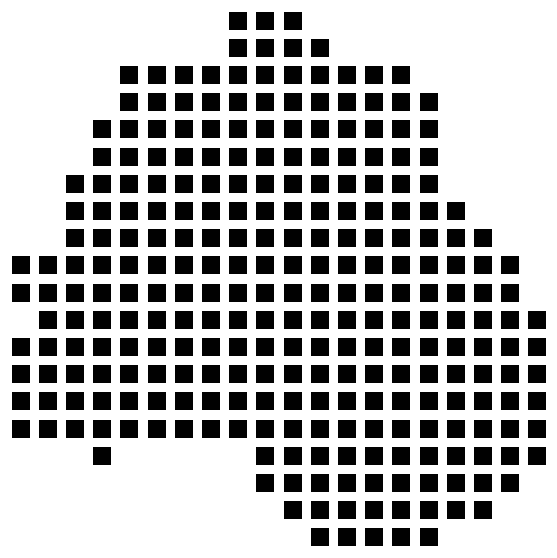

In [ ]:
import torch.nn.functional as F

# Create black & white atlas
atlas_bw_tensors = [
    F.pad(torch.ones(1, 3, 4, 4) * 255, (1, 1, 1, 1), value=1) for n in vec_coords
]
atlas_bw = opt.atlas.create_atlas(
    atlas_bw_tensors, vec_coords, grid_size=grid_size
)

# Make background transparent
alpha_bw_mask = create_alpha_mask(6, 6, coords=vec_coords, device=atlas_bw.device)
atlas_bw = torch.cat([atlas_bw, alpha_bw_mask], 1)

show(atlas_bw, figsize=(10, 10))

We can also see which atlas cells have the most samples like so (the darker the color, the more activation samples used):

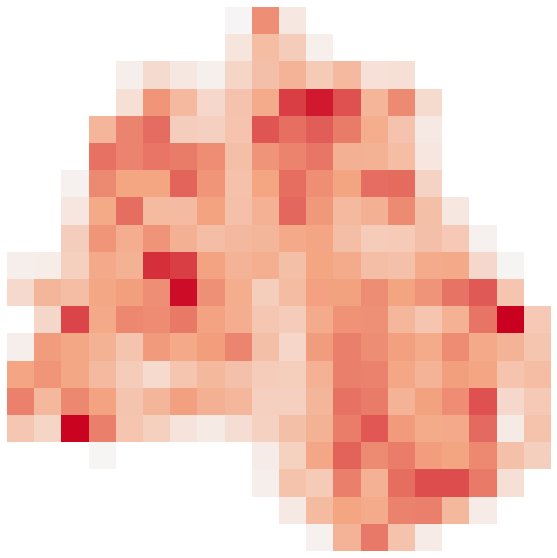

In [ ]:
# Create heatmap atlas
atlas_hm_tensors = [torch.ones(1, 1, 1, 1) * n[2] for n in vec_coords]
atlas_hm = opt.atlas.create_atlas(
    atlas_hm_tensors, vec_coords, grid_size=grid_size
)
atlas_hm = atlas_hm / atlas_hm.max()
atlas_hm = opt.weights_to_heatmap_2d(atlas_hm[0, 0])

# Make background transparent
alpha_hm_mask = create_alpha_mask(1, 1, coords=vec_coords, device=atlas_hm.device)
atlas_hm = torch.cat([atlas_hm.unsqueeze(0), alpha_hm_mask], 1)

show(atlas_hm, figsize=(10, 10))

## Rendering The Activation Atlas Visualizations

Now we should have everything we need to start rendering the visualizations for each activation atlas cell!

To create the visualizations for our atlas we will use the `AngledNeuronDirection` objective, which places more emphasis on angle than the default direction objectives.

In [ ]:
def vis_neuron_direction(
    model: torch.nn.Module,
    target: torch.nn.Module,
    vec: torch.Tensor,
    vec_whitened: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    image = opt.images.NaturalImage((80, 80)).to(device)
    loss_fn = opt.loss.AngledNeuronDirection(
        target, vec, vec_whitened, cossim_pow=4.0
    )
    transforms = torch.nn.Sequential(
        torch.nn.ConstantPad2d(2, value=1.0),
        opt.transform.RandomSpatialJitter(4),
        opt.transform.RandomSpatialJitter(4),
        opt.transform.RandomSpatialJitter(8),
        opt.transform.RandomSpatialJitter(8),
        opt.transform.RandomSpatialJitter(8),
        opt.transform.RandomScale(
            scale=[0.995 ** n for n in range(-5, 80)]
            + [0.998 ** n for n in 2 * list(range(20, 40))]
        ),
        opt.transform.RandomRotation(
            degrees=list(range(-20, 20))
            + list(range(-10, 10))
            + list(range(-5, 5))
            + 5 * [0]
        ),
        opt.transform.RandomSpatialJitter(2),
    )
    obj = opt.InputOptimization(model, image, transforms, [target], loss_fn)
    history = obj.optimize(opt.objectives.n_steps(128, False))
    return image()._t, history[-1]

We whiten the raw Mixed4c ReLU activation samples to help unstretch the activation space for the `AngledNeuronDirection` objective. Note that some models (like the InceptionV1 Places365 model) perform better without whitened activation samples, and thus `whitend_activation_samples` can set to `None` for those cases.

In [ ]:
# Whiten the raw activations
whitend_activation_samples = torch.inverse(
    torch.matmul(activation_samples.T, activation_samples)
    / len(activation_samples)
)

To generate all of the activation atlas images, we'll iterate through all the previously calculated direction vectors. To monitor our progress, we will use the `tqdm` library. To maximize atlas quality, we can optionally try rendering multiple attempts of each visualization and then keeping the attempt with the highest loss value.

In [ ]:
from tqdm import tqdm

A = []
num_attempts = 1

for i in tqdm(range(vecs.size(0)), position=0, leave=True):
    attempts, loss_list = [], []
    for a in range(num_attempts):
        img, loss = vis_neuron_direction(
            model, model.mixed4c, vec=vecs[i], vec_whitened=whitend_activation_samples
        )
        attempts.append(img.detach().cpu())
        loss_list.append(loss)

    A.append(attempts[np.argmax(np.asarray(loss_list))])

100%|██████████| 273/273 [21:26<00:00,  4.71s/it]


Now we put all the images together using the cell coordinates that we previously calculated!

To put the atlas cells together, we'll use the `create_atlas` function. The `create_atlas` takes the following inputs and returns a complete atlas:

* `cells`: A list of NCHW image tensors that are all the same shape.

* `coords`: A list of coordinates that correspond to the inputs to `cells`.

* `grid_size` The same grid size that was used to create the atlas visualizations and coordinates.

The resulting atlas will match the number of channels used in the input cells. Thus, this flexibility of the `create_atlas` function allows us to do things like create a alpha transparency mask in order to make the background transparent! We can also slice the list of coordinates to match the number of visualizations that we created, for if we didn't render all the cells.

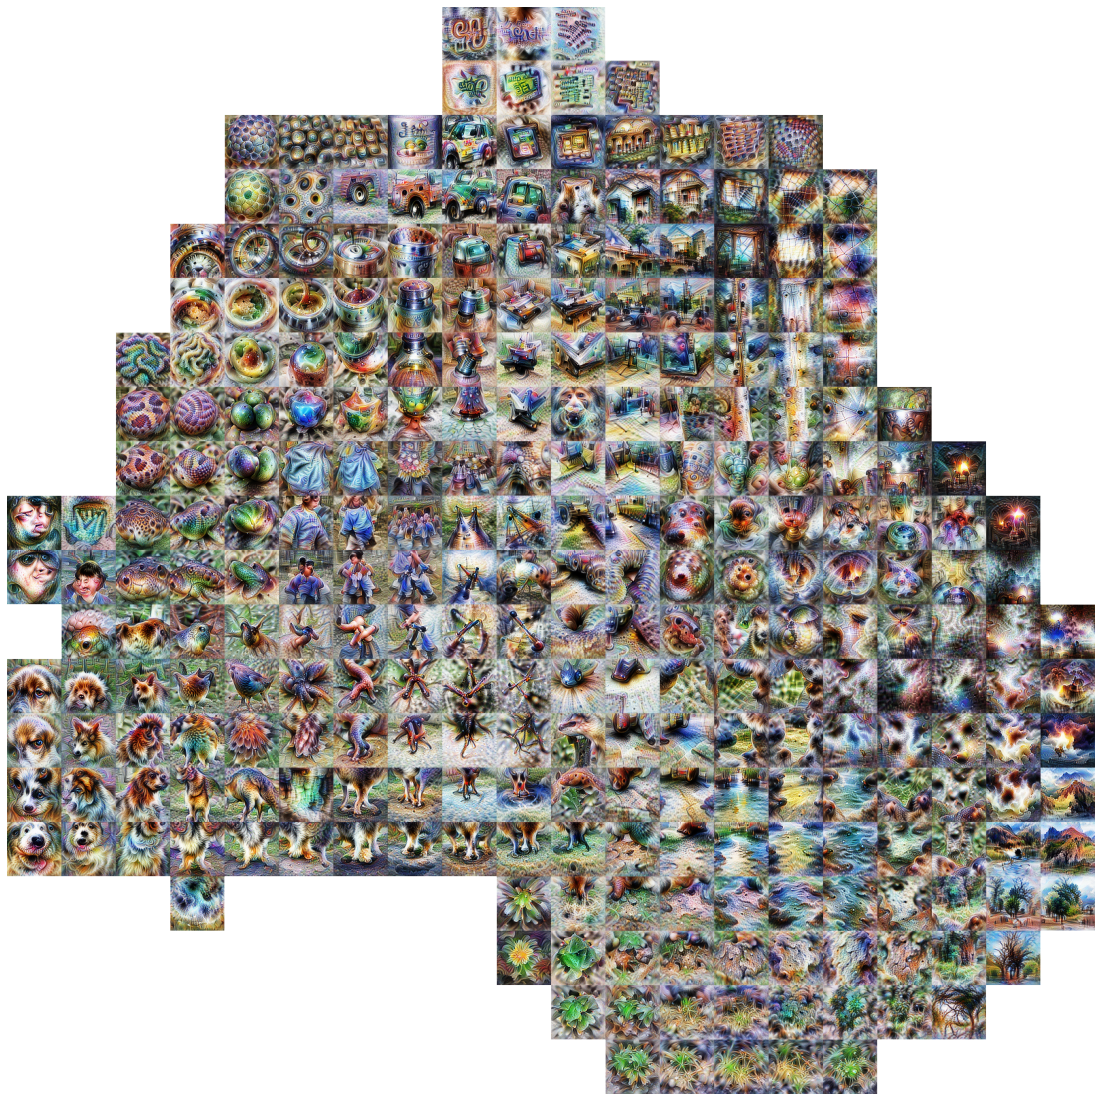

In [ ]:
atlas_img_rgb = opt.atlas.create_atlas(A, vec_coords[: len(A)], grid_size=grid_size)

# Make background transparent
alpha_mask = create_alpha_mask(
    *A[0].shape[2:], coords=vec_coords[: len(A)], device=atlas_img_rgb.device
)
atlas_img = torch.cat([atlas_img_rgb, alpha_mask], 1)

# Save atlas as image and show it to user
save_tensor_as_image(atlas_img.detach(), "atlas.png")
show(atlas_img.detach(), figsize=(20, 20))

Looking at the full activation atlas, we can see that concepts are grouped together based on similarity! It is also possible to trace paths of how a concept changes across the atlas!

We can also identify possible adversarial attack images by looking closely at what the nearby visualizations of a target concept visualization are.

## Class Filtering of Activation Atlases

Now that we have the full activation atlas, we can visualize what parts of our newly created atlas correspond most strongly to a target class like so:

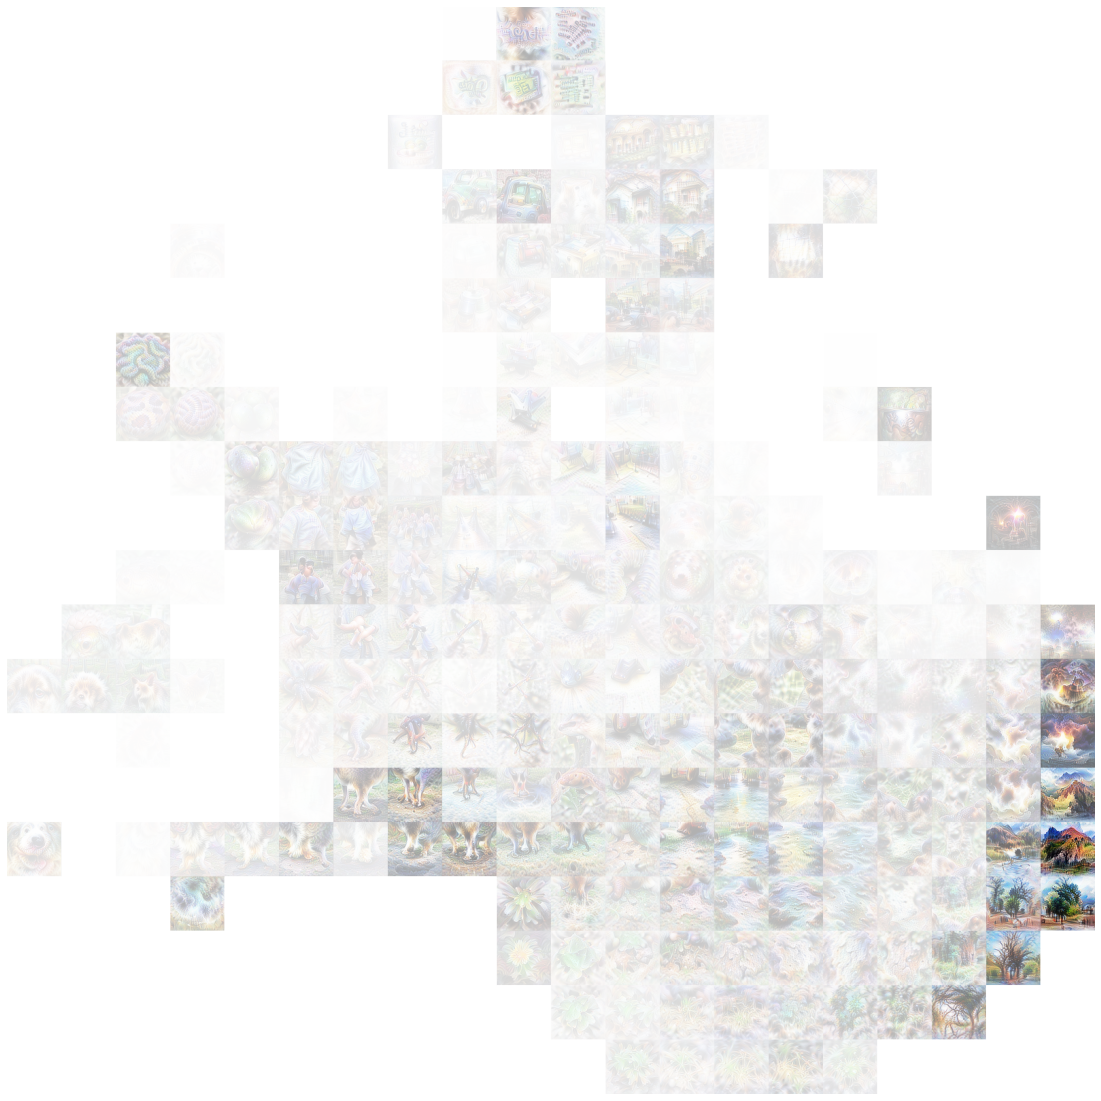

In [ ]:
class_id = 366  # lakeside

# Extract attributions corresponding to our atlas cells
indices = opt.atlas.calc_grid_indices(
    opt.atlas.normalize_grid(xy_grid), grid_size=grid_size
)
cell_attrs = (
    extract_grid_attributions(
        grid_indices=indices,
        raw_attributions=sample_attributions,
        grid_size=grid_size,
        target_class_ids=class_id,
        min_density=min_density,
    )
)[: len(A)]
cell_attrs = torch.nn.functional.relu(cell_attrs) / cell_attrs.max()

class_mask = opt.atlas.create_atlas(
    [
        torch.ones(1, 1, *A[0].shape[2:], device=A[0].device) * attr_val
        for attr_val in cell_attrs.cpu()
    ],
    coords=vec_coords[: len(A)],
    grid_size=grid_size,
    base_tensor=torch.zeros,
)

# Make background transparent & set cell transparency
# based on attribution strength
alpha_mask = create_alpha_mask(
    *A[0].shape[2:], coords=vec_coords[: len(A)], device=atlas_img_rgb.device
) * class_mask
atlas_img = torch.cat([atlas_img_rgb, alpha_mask], 1)

# Save atlas as image and show it to user
save_tensor_as_image(atlas_img.detach(), "atlas_class_" + str(class_id) +".png")
show(atlas_img.detach(), figsize=(20, 20))